In [1]:
import pandas as pd
import os
import dask.dataframe as dd
from pathlib import Path
import subprocess as sp
import math
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import itertools

In [2]:
def genome_TSS_annotation(genome_path_gtf, TSS_gtf):
    """
    Takes a ensemble genome gtf file as input, and returns a smaller gtf file containing only the genes and
    their TSS locations
    """
    Path(f"{TSS_gtf}").touch()
    tempfile = os.getcwd() + "/temp_TSS_genome_annotation.txt"
    Path(tempfile).touch()
    os.remove(f"{TSS_gtf}")
    # i = 0
    with open(f"{tempfile}", "a") as output_gtf:
        with open(genome_path_gtf) as f:
            for _ in range(5):
                next(f)
            for line in f:
                line = line.strip()
                line = line.split()
                gene_name = line[13]
                coding_stuff = line[17]
                strand_info = line[6]
                #             if i == 1000:
                #                 break
                #             i = i + 1
                gene_name = gene_name.rstrip(";")
                coding_stuff = coding_stuff.rstrip(";")
                # coding_stuff = coding_stuff.rstrip(";")
                if str(coding_stuff) == '"protein_coding"':
                    if line[6] == "+":
                        start = line[3]
                        end = int(start) + 1
                        output_gtf.write(
                            line[0]
                            + "\t"
                            + str(start)
                            + "\t"
                            + str(end)
                            + "\t"
                            + gene_name
                            + "\n"
                        )
                    else:
                        start = int(line[4]) - 1
                        end = line[4]
                        output_gtf.write(
                            line[0]
                            + "\t"
                            + str(start)
                            + "\t"
                            + str(end)
                            + "\t"
                            + gene_name
                            + "\n"
                        )
    sp.check_call(
        f"nice -5 bedtools sort " f"-i {tempfile} " f"> {TSS_gtf}", shell=True,
    )
    os.remove(tempfile)

In [3]:
def TSS_window_to_region(genome_TSS_gtf, bedregion_file, TSS_window):
    """
    Takes a genome TSS gtf file or bedfile as input (see the 'genome_TSS_GTF' script) together with a bed file 
    with regions and a window length.
    It wil subsequently take a window around the TSS, and list all regions overlapping with this window. It will
    furhtermore calculate the distance of te bedregion to the TSS.
    It will return a dataframe containing all these results.
    """
    sp.check_call(
        f"nice -10 bedtools window "
        f"-w {TSS_window} "
        f"-a {genome_TSS_gtf} "
        f"-b {bedregion_file} "
        f"> tmp_bedtool_window.txt",
        shell=True,
    )
    pd_table = pd.read_table(
        "tmp_bedtool_window.txt",
        index_col=None,
        names=[
            "chr_TSS",
            "start_TSS",
            "end_TSS",
            "gene_name",
            "Chrom",
            "ChromStart",
            "ChromEnd",
        ],
        dtype={
            "chr_TSS": str,
            "start_TSS": int,
            "end_TSS": int,
            "gene_name": str,
            "Chrom": str,
            "ChromStart": int,
            "ChromEnd": int,
        },
    )
    os.remove("tmp_bedtool_window.txt")
    distance = (
        []
    )  # calculate the distance based on the TSS start end region start site, check which one is upstream for distance calc.
    for x, y in zip(pd_table["start_TSS"], pd_table["ChromStart"]):
        if x > y:
            distance.append(x - y)
        elif y > x:
            distance.append(y - x)
        else:
            distance.append("NaN")
    pd_table["distance"] = distance
    return pd_table

In [59]:
def distance_weight(include_promoter=False, include_enhancer=True, alpha=1e5, padding=100000, keep1=5000, remove=2000):
    """
    Built weight distribution from TSS. (From Ananse)
    """
    # alpha is half site, default setting is 1e5, which means at 1e5 position weight is 0.5
    # padding is the full range we used
    # remove is promoter removed range
    # keep1 is keep full binding score range
    u = -math.log(1.0 / 3.0) * 1e5 / alpha
    if include_promoter and include_enhancer:
        weight1 = pd.DataFrame(
            {"weight": [1 for z in range(1, remove + 1)], "dist": range(1, remove + 1)}
        )
        weight2 = pd.DataFrame(
            {
                "weight": [1 for z in range(remove + 1, keep1 + 1)],
                "dist": range(remove + 1, keep1 + 1),
            }
        )
        weight3 = pd.DataFrame(
            {
                "weight": [
                    2.0
                    * math.exp(-u * math.fabs(z) / 1e5)
                    / (1.0 + math.exp(-u * math.fabs(z) / 1e5))
                    for z in range(1, padding - keep1 + 1)
                ],
                "dist": range(keep1 + 1, padding + 1),
            }
        )
    elif not include_promoter and include_enhancer:
        weight1 = pd.DataFrame(
            {"weight": [0 for z in range(1, remove + 1)], "dist": range(1, remove + 1)}
        )
        weight2 = pd.DataFrame(
            {
                "weight": [1 for z in range(remove + 1, keep1 + 1)],
                "dist": range(remove + 1, keep1 + 1),
            }
        )
        weight3 = pd.DataFrame(
            {
                "weight": [
                    2.0
                    * math.exp(-u * math.fabs(z) / 1e5)
                    / (1.0 + math.exp(-u * math.fabs(z) / 1e5))
                    for z in range(1, padding - keep1 + 1)
                ],
                "dist": range(keep1 + 1, padding + 1),
            }
        )
    elif include_promoter and not include_enhancer:
        weight1 = pd.DataFrame(
            {"weight": [1 for z in range(1, remove + 1)], "dist": range(1, remove + 1)}
        )
        weight2 = pd.DataFrame(
            {
                "weight": [0 for z in range(remove + 1, keep1 + 1)],
                "dist": range(remove + 1, keep1 + 1),
            }
        )
        weight3 = pd.DataFrame(
            {
                "weight": [0 for z in range(1, padding - keep1 + 1)],
                "dist": range(keep1 + 1, padding + 1),
            }
        )
    else:
        weight1 = pd.DataFrame(
            {"weight": [0 for z in range(1, remove + 1)], "dist": range(1, remove + 1)}
        )
        weight2 = pd.DataFrame(
            {
                "weight": [0 for z in range(remove + 1, keep1 + 1)],
                "dist": range(remove + 1, keep1 + 1),
            }
        )
        weight3 = pd.DataFrame(
            {
                "weight": [0 for z in range(1, padding - keep1 + 1)],
                "dist": range(keep1 + 1, padding + 1),
            }
        )
    weight = pd.concat([weight1, weight2, weight3])
    weight_dict = pd.Series(weight.weight.values, index=weight.dist).to_dict()
    return weight_dict

In [5]:
#load the table to convert the chromosome names to the USCS format
CRCH38_ensembl2UCSC = pd.read_csv('/scratch/bacint/jdeleuw/KC_ATAC/analysis/bigBed/CRCH38_ensembl2UCSC.txt', sep ='\t',header = 0, index_col=False)

#make dictionary which can be used to convert ensembl to UCSC format 
ensembl_to_UCSC = {}
UCSC_to_ensembl = {}
for row in CRCH38_ensembl2UCSC.itertuples():
    ensembl_to_UCSC[row[1]] = row[2]
    UCSC_to_ensembl[row[2]] = row[1]

# Load data

In [6]:
#import TFs of interest
TFs = pd.read_csv('/scratch/bacint/jdeleuw/ananse/analysis/interesting_TFs.csv', header = None)

In [7]:
variable_names = pd.read_csv('/scratch/bacint/jdeleuw/ananse/binding_data/binding_analysis/Variable_names.csv', sep = ',', header = 0, index_col = 0)

In [9]:
#import binding files
os.chdir('/scratch/bacint/jdeleuw/ananse/binding_data')
for index in variable_names.index:
    path_list = [os.getcwd(), '/binding_', index, '.txt']
    path = ''.join(path_list)
    globals()[index] = dd.read_csv(path, sep='\t', engine='python', usecols= ['factor', 'enhancer', 'binding'])

/scratch/bacint/jdeleuw/second_ananse/binding_data2/binding_day0.txt
/scratch/bacint/jdeleuw/second_ananse/binding_data2/binding_day07.txt
/scratch/bacint/jdeleuw/second_ananse/binding_data2/binding_day14.txt
/scratch/bacint/jdeleuw/second_ananse/binding_data2/binding_day21.txt
/scratch/bacint/jdeleuw/second_ananse/binding_data2/binding_day43.txt
/scratch/bacint/jdeleuw/second_ananse/binding_data2/binding_day60.txt
/scratch/bacint/jdeleuw/second_ananse/binding_data2/binding_KC.txt


# Filter TFs

In [10]:
#filter TFs of interest from binding files
binding_dfs = [globals()[i] for i in dir() if re.match('^day.', i)]
binding_dfs.extend([globals()[i] for i in dir() if re.match('KC', i)])

for name, binding_df in zip(variable_names.TF_filtered_binding_dfs, binding_dfs):
    globals()[name] = binding_df[binding_df['factor'].isin(TFs[0].tolist())].compute()

# Get all the enhancer within 100 kb window of TSS and calculate the distance

In [11]:
TF_filtered_dfs = [globals()[i] for i in dir() if re.search('^filtered_Day.$', i) 
                   or re.search('^filtered_Day..$', i) 
                   or re.search('^filtered_KC$', i)]

for df, day in zip(TF_filtered_dfs, variable_names.index):
    enhancer_duplicates = df['enhancer'].str.split(':|-', n = 2, expand = True)
    enhancer = enhancer_duplicates.drop_duplicates()
    enhancer_ensembl = enhancer.replace({0 : UCSC_to_ensembl})
    
    path_list = ['/scratch/bacint/jdeleuw/ananse/binding_data/binding_analysis/bed_files/', day, '.bed']
    path = ''.join(path_list)
    
    enhancer_ensembl.to_csv(path, sep = '\t', header = False, index = False)

In [12]:
#subset the TSS of each gene from the GTF file
genome_TSS_annotation('/scratch/bacint/jdeleuw/genomes/GRCh38.p13/GRCh38.p13.annotation.gtf', 
                      '/scratch/bacint/jdeleuw/genomes/GRCh38.p13/GRCh38.p13.small.annotation.gtf')

In [53]:
#Make df with TSS and enhancers within 100 kb
TF_filtered_dfs = [globals()[i] for i in dir() if re.search('^filtered_Day.$', i) 
                   or re.search('^filtered_Day..$', i) 
                   or re.search('^filtered_KC$', i)]

for binding_df, day, output_name in zip(TF_filtered_dfs, variable_names.index, variable_names.distance_TSS_enhancer):
    path_list = ['/scratch/bacint/jdeleuw/ananse/binding_data/binding_analysis/bed_files/', day, '.bed']
    path = ''.join(path_list)
    
    df = TSS_window_to_region('/scratch/bacint/jdeleuw/genomes/GRCh38.p13/GRCh38.p13.small.annotation.gtf',
                                                   path,
                                                   100000)
    #filter TF of interest(influence_score >= 0.95) from the df
    filtered_df = df[df['gene_name'].isin(TFs[0].tolist())]
    
    #merge df with TSS and linked enhancers, with the factor binding to the enhancer with the binding score
    filtered_df = filtered_df.replace({'Chrom': ensembl_to_UCSC})
    filtered_df['enhancer'] = filtered_df[['Chrom', 'ChromStart']].astype(str).agg(':'.join, axis=1)
    filtered_df['enhancer'] = filtered_df[['enhancer', 'ChromEnd']].astype(str).agg('-'.join, axis=1)
    
    if day == 'day0':
        merged_df_temp = filtered_df.merge(binding_df, how = 'inner', on = 'enhancer')
        merged_df = merged_df_temp.rename(columns = {'binding' : 'binding_day0'})
    else: 
        merged_df['binding_' + day] = filtered_df.merge(binding_df, how = 'inner', on = 'enhancer')['binding']

# Normalize the binding score based on the distance
# How are the TFs of each cluster targeted by all the TFs

In [40]:
Cluster1 = ['NANOG', 'SOX2', 'SALL4', 'PRDM14', 'ZSCAN10', 'OTX2', 'ZIC3', 'ZFP42', 'MYCN', 'FOXH1']
Cluster2 = ['MYC']
Cluster3 = ['MEIS1', 'HAND1', 'MSX2', 'HOXB2', 'MEIS2', 'HEY1', 'TBX3', 'TFAP2B']
Cluster4 = ['TP63', 'MAF', 'EHF', 'HES2']
Cluster5 = ['EPAS1', 'CEBPD', 'KLF5', 'IRF6', 'GRHL1', 'FOSL2', 'SNAI2']
Cluster6 = ['IRF9', 'IRX3', 'OSR1', 'HOXB1']

In [56]:
#add weight based on the distance from the binding site to the TSS
Cluster_list = [globals()[i] for i in dir() if re.search('^Cluster.$', i)]

weights = distance_weight(alpha=1e4, include_promoter=False)
test = merged_df.copy()

for Cluster, output_name in zip(Cluster_list, variable_names.targeted_cluster_hm):
    hm_data = pd.DataFrame(index = TFs[0], columns = variable_names.index)
    for day in variable_names.index:
        test['weight'] = test['distance'].map(weights)
        test['binding_weight_' + day] = test['binding_' + day] * test['weight']      

        regulation_probability = pd.DataFrame(index = TFs[0], columns = TFs[0])
        for target_gene, TF in itertools.product(Cluster, TFs[0]):
            filtered_target = test[test['gene_name'].isin([target_gene])]
            filtered_TF = filtered_target[filtered_target['factor'].isin([TF])]

            regulation_probability.at[target_gene, TF] = filtered_TF['binding_weight_' + day].sum()
        for TF in TFs[0]:
            regulation_probability.replace(0, np.nan, inplace=True)
            hm_data.at[TF, day] = regulation_probability.loc[:, TF].mean()
        globals()[output_name] = hm_data
        path_list = ['/scratch/bacint/jdeleuw/ananse/binding_data/binding_analysis/', output_name, '.tsv']
        path = ''.join(path_list)
        hm_data.to_csv(path, sep='\t')

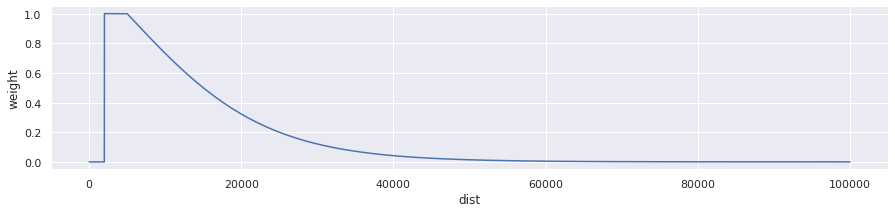

In [60]:
sns.set(rc={"figure.figsize": (15, 3)})
# import from Ananse
weight = distance_weight(alpha=1e4, include_promoter=False)
sns.lineplot(x=weight["dist"], y=weight["weight"])
plt.savefig(f"/scratch/bacint/jdeleuw/ananse/binding_data/binding_analysis/weight_distance_enhancer_window.pdf")
enh_weight_dict = pd.Series(weight.weight.values, index=weight.dist).to_dict()